In [1]:
# train_bow_nb.py

import re
import pickle
import numpy as np
import pandas as pd

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

# download stopwords and prepare stopword set
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

# prepare stemmer
factory = StemmerFactory()
stemmer = nltk.stem.SnowballStemmer("english")

# load and filter hoax news
hoax = pd.read_csv("../Dataset/hoax_news.csv", usecols=["Title", "Narasi", "category"]) \
          .dropna(subset=["Title", "Narasi", "category"])
hoax = hoax[~hoax["category"].isin(["Benar", "Disinformasi"])]
hoax = hoax.rename(columns={"Title": "title", "Narasi": "body"})
hoax["label"] = "hoax"

# load and label real news
real = pd.read_csv("../Dataset/detik_news.csv", usecols=["page", "title", "url", "content"]) \
           .dropna(subset=["title", "content"])
real = real.rename(columns={"content": "body"})
real["label"] = "real"
real = real[["title", "body", "label"]]

# remove outliers in hoax based on text length
for field in ["title", "body"]:
    lengths = hoax[field].str.len()
    q1, q3 = lengths.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    hoax = hoax[(lengths >= lower) & (lengths <= upper)]
hoax = hoax.drop(columns=["category"])

# balance classes by downsampling to smallest class size
df = pd.concat([hoax, real], ignore_index=True)
min_size = df["label"].value_counts().min()
df = df.groupby("label", group_keys=False).apply(lambda g: g.sample(min_size, random_state=42))

# split into training, validation, and test sets (70/20/10)
X = df[["title", "body"]].astype(str)
y = df["label"]
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
val_fraction = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_fraction, stratify=y_temp, random_state=42)

# function to clean, tokenize, and stem text
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# apply preprocessing to each split
for subset in (X_train, X_val, X_test):
    subset["text"] = (
        subset["title"].apply(clean_tokenize).apply(" ".join)
        + " "
        + subset["body"].apply(clean_tokenize).apply(" ".join)
    )

# convert text to bag-of-words features limited to 1000 tokens
vectorizer = CountVectorizer(max_features=1000)
X_train_bow = vectorizer.fit_transform(X_train["text"])
X_val_bow = vectorizer.transform(X_val["text"])
X_test_bow = vectorizer.transform(X_test["text"])

# perform feature masking augmentation (40% masked)
mask_prob = 0.40
rng = np.random.default_rng(42)
base_array = X_train_bow.toarray()
mask = rng.binomial(1, 1 - mask_prob, size=base_array.shape)
augmented_array = base_array * mask

X_train_final = np.vstack([base_array, augmented_array])
y_train_final = np.hstack([y_train.values, y_train.values])

# train a Multinomial Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_final, y_train_final)

# evaluate on validation set
val_preds = nb.predict(X_val_bow.toarray())
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds, digits=3))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, val_preds, labels=["hoax", "real"]))

# evaluate on test set
test_preds = nb.predict(X_test_bow.toarray())
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds, digits=3))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, test_preds, labels=["hoax", "real"]))

# save the pipeline for later use
with open("nb_bow_aug_hoax.pkl", "wb") as f:
    pickle.dump({
        "model":       nb,
        "vectorizer":  vectorizer,
        "stopwords":   stops,
        "mask_prob":   mask_prob,
        "stemmer":     stemmer
    }, f)

print("Saved BOW+NaiveBayes pipeline to nb_bow_aug_hoax.pkl")

Validation Accuracy: 0.9332985930171964
              precision    recall  f1-score   support

        hoax      0.983     0.882     0.930       959
        real      0.893     0.984     0.937       960

    accuracy                          0.933      1919
   macro avg      0.938     0.933     0.933      1919
weighted avg      0.938     0.933     0.933      1919

Validation Confusion Matrix:
[[846 113]
 [ 15 945]]
Test Accuracy: 0.9416058394160584
              precision    recall  f1-score   support

        hoax      0.969     0.912     0.940       480
        real      0.917     0.971     0.943       479

    accuracy                          0.942       959
   macro avg      0.943     0.942     0.942       959
weighted avg      0.943     0.942     0.942       959

Test Confusion Matrix:
[[438  42]
 [ 14 465]]
Saved BOW+NaiveBayes pipeline to nb_bow_aug_hoax.pkl


OOD Results for Naive Bayes + BOW
Accuracy: 0.7466666666666667
              precision    recall  f1-score   support

        hoax      0.739     0.812     0.774        80
        real      0.758     0.671     0.712        70

    accuracy                          0.747       150
   macro avg      0.748     0.742     0.743       150
weighted avg      0.748     0.747     0.745       150



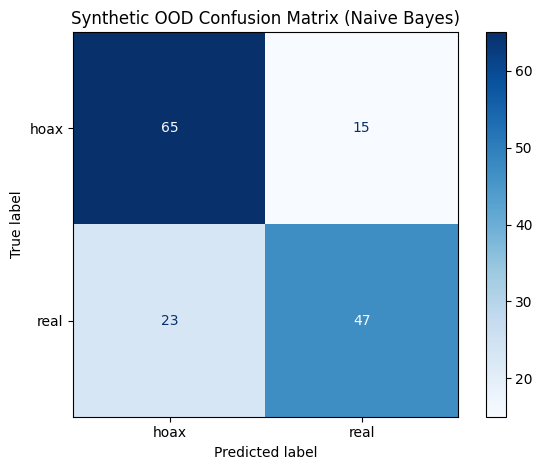

In [2]:
# test_bow_nb_synthetic.py

import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# load the saved Naive Bayes + BOW pipeline
with open("nb_bow_aug_hoax.pkl", "rb") as f:
    data         = pickle.load(f)
    nb_model     = data["model"]
    vectorizer   = data["vectorizer"]
    stops        = data["stopwords"]
    stemmer      = data.get("stemmer")  # if you need stemming, otherwise ignore

# define text cleaning and tokenization that matches training
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    if stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    return tokens

# read the synthetic OOD dataset, expecting title, body, label per line
titles, bodies, true_labels = [], [], []
with open("../Dataset/synthetic_news.txt", "r", encoding="utf-8") as f:
    for line in f:
        t, b, lab = line.strip().split("\t")
        titles.append(t)
        bodies.append(b)
        true_labels.append(lab)

# build the combined text for each example
texts = [
    " ".join(clean_tokenize(t) + clean_tokenize(b))
    for t, b in zip(titles, bodies)
]

# vectorize the texts into BOW features
X_syn = vectorizer.transform(texts).toarray()

# predict labels on the synthetic OOD set
preds = nb_model.predict(X_syn)

# print overall performance metrics
print("OOD Results for Naive Bayes + BOW")
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds, digits=3))

# display the confusion matrix
cm = confusion_matrix(true_labels, preds, labels=["hoax", "real"])
disp = ConfusionMatrixDisplay(cm, display_labels=["hoax", "real"])
disp.plot(cmap="Blues")
plt.title("Synthetic OOD Confusion Matrix (Naive Bayes)")
plt.tight_layout()
plt.show()
